In [1]:
import os
import numpy as np
import pandas as pd
import sys
import json

# Add rpy2
%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(ComplexHeatmap)
    library(cowplot)
    library(facefuns)
    library(factoextra)
    library(FactoMineR)
    library(ggh4x)
    library(ggpubr)
    library(ggrain)
    library(ggridges)
    library(ggseg)
    library(ggsegDesterieux)
    library(ggsignif)
    library(glue)
    library(LaCroixColoR)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
})


# Set cowplot theme
theme_set(theme_cowplot())

In addition: Warning message:
package ‘broom’ was built under R version 4.3.3 


In [3]:
# Load classification res
classification_res_path = "/Users/abry4213/data/Cogitate_MEG_challenge/derivatives/classification_results"

stimulus_type_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_classification_results.csv")

# SPI directionality info
SPI_directionality_info = pd.read_csv("/Users/abry4213/github/Cogitate_Connectivity_2024/feature_extraction/pyspi_SPI_info.csv")

# Read in meta-ROI data from .json
with open("/Users/abry4213/github/Cogitate_Connectivity_2024/hypothesis_driven_ROIs.json") as f:
    meta_ROI_dict = json.load(f)
# Prepare a list of tuples
rows = []
for key, values in meta_ROI_dict.items():
    for value in values:
        rows.append((key, value))
# Convert list of tuples to DataFrame
meta_ROI_df = (pd.DataFrame(rows, columns=['meta_ROI', 'region'])
               .assign(region = lambda x: x.region.str.replace("_", " ")))


What is the spatial layout of the three meta-ROIs in the brain?

In [9]:
%%R -i meta_ROI_df

meta_ROI_df_to_plot <- meta_ROI_df %>% 
  rowwise() %>%
  mutate(meta_ROI = str_split(meta_ROI, "_ROIs")[[1]][1])

ggseg(atlas = desterieux, 
      mapping = aes(fill = meta_ROI), .data=meta_ROI_df_to_plot,
      color = "gray30", position = "stacked") +
  theme_void() +
  labs(title="Cogitate Challenge Regions", fill="Meta-ROI") +
  scale_fill_manual(values = c("Category_Selective" = "#DB582D",
                               "GNWT" = "#479D72",
                               "IIT" = "#346DB0"),
                    na.value = 'white') +
  theme(legend.position = "bottom")
ggsave('plots/Cogitate_Meta_ROIs.svg', width=5, height=3, units='in', dpi=300)

merging atlas and data by 'region'


In [10]:
stimulus_type_classification_res_cleaned_list = []

for SPI in stimulus_type_classification_res.SPI.unique():

    # Load SPI data
    this_SPI_data = stimulus_type_classification_res.query("SPI==@SPI")

    # Look up directionality
    this_SPI_directionality = SPI_directionality_info.query(f"SPI == '{SPI}'").Directionality.values[0]

    # Merge meta ROIs according to directionality
    if this_SPI_directionality == "Directed":
        this_SPI_data["meta_ROI_pair"] = this_SPI_data.meta_ROI_from + "_" + this_SPI_data.meta_ROI_to
        this_SPI_data = this_SPI_data.drop(["meta_ROI_from", "meta_ROI_to"], axis=1)
    else:
        this_SPI_data_sorted = [sorted(pair) for pair in this_SPI_data[["meta_ROI_from", "meta_ROI_to"]].values.tolist()]
        this_SPI_data['meta_ROI_pair'] = ['_'.join(string) for string in this_SPI_data_sorted]
        this_SPI_data = (this_SPI_data
                    .drop(["meta_ROI_from", "meta_ROI_to"], axis=1)
                    .drop_duplicates(ignore_index=True, subset=['relevance_type', 'stimulus_presentation', 'stimulus_combo', 'meta_ROI_pair'])
                    )
        
    stimulus_type_classification_res_cleaned_list.append(this_SPI_data)

stimulus_type_classification_res_cleaned = pd.concat(stimulus_type_classification_res_cleaned_list)

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_52149/1468146448.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_SPI_data['meta_ROI_pair'] = ['_'.join(string) for string in this_SPI_data_sorted]
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_52149/1468146448.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_SPI_data['meta_ROI_pair'] = ['_'.join(string) for string in this_SPI_data_sorted]
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_52149/1468146448.py:1

In [27]:
%%R -i stimulus_type_classification_res_cleaned -w 700 -h 550 

stimulus_type_classification_res_cleaned %>% 
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy, 
           stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off"))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_pair, y=accuracy, fill=stimulus_presentation)) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=2)  +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.4, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    geom_point(aes(color = stimulus_presentation), 
        position = position_jitterdodge(jitter.width = 0.1, jitter.height=0, dodge.width=0.5),
                                        size = 1.5, alpha=0.6, stroke=0) +
    scale_fill_manual(values = c("on" = "red", "off" = "gray70")) +
    scale_color_manual(values = c("on" = "red", "off" = "gray70")) +
    facet_wrap(stimulus_combo ~ ., scales="free_x") + 
    theme(legend.position = "bottom") +
    xlab("Meta-ROI Pair") +
    ylab("Cross-validated accuracy (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
    axis.text.x = element_text(angle=45, hjust=1))

ggsave('plots/Stimulus_wise_classificatin_performance_by_meta_ROI_pair.svg', width=6, height=9, units='in', dpi=300)

In [58]:
%%R -i stimulus_type_classification_res_cleaned

for (i in 1:6) {
    this_combo = (unique(stimulus_type_classification_res_cleaned$stimulus_combo)[i])

    stimulus_one <- strsplit(this_combo, "'")[[1]][2]
    stimulus_two <- strsplit(this_combo, "'")[[1]][4]

    stimulus_type_classification_res_cleaned %>%
        filter(stimulus_combo == this_combo) %>%
        group_by(SPI) %>%
        filter(any(accuracy > 0.65)) %>% 
        ungroup() %>%
        mutate(accuracy = 100*accuracy) %>%
        mutate(accuracy = ifelse(accuracy<50, 50, accuracy), 
            SPI = fct_reorder(SPI, accuracy, .fun="mean"), 
            stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off")),
            relevance_type = factor(relevance_type, levels = c("Relevant non-target", "Irrelevant"))) %>%
        ggplot(data=., mapping=aes(y=SPI, x=meta_ROI_pair, fill=accuracy)) +
        geom_tile() +
        facet_grid(. ~ relevance_type + stimulus_presentation, scales="free_x") +
        scale_fill_gradient(low="white", high="#9E489D", limits=c(50, 75)) +
        theme(axis.text.x = element_text(angle=90, hjust=1))  +
        labs(fill = "Accuracy (%)") + 
        theme(strip.background = element_blank())

    ggsave(sprintf("plots/SPI_wise_performance_%s_vs_%s_by_meta_ROI_pair.svg", stimulus_one, stimulus_two), width=10, height=6, units='in', dpi=300)
}


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [59]:
stimulus_type_classification_res_cleaned.head()

,SPI,relevance_type,stimulus_presentation,stimulus_combo,accuracy,meta_ROI_pair
0,cov_EmpiricalCovariance,Relevant non-target,on,"('False', 'face')",0.4875,Category_Selective_GNWT
1,cov_EmpiricalCovariance,Relevant non-target,on,"('False', 'letter')",0.5000,Category_Selective_GNWT
2,cov_EmpiricalCovariance,Relevant non-target,on,"('False', 'object')",0.5000,Category_Selective_GNWT
3,cov_EmpiricalCovariance,Relevant non-target,on,"('face', 'letter')",0.5000,Category_Selective_GNWT
4,cov_EmpiricalCovariance,Relevant non-target,on,"('face', 'object')",0.5000,Category_Selective_GNWT


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


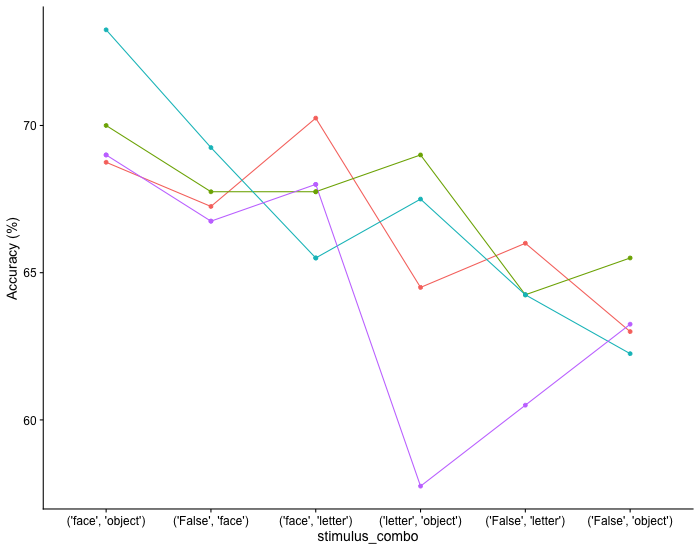

In [67]:
%%R -i stimulus_type_classification_res_cleaned  -w 700 -h 550 

stimulus_type_classification_res_cleaned %>% 
    group_by(meta_ROI_pair, stimulus_combo) %>% 
    filter(accuracy == max(accuracy)) %>% 
    mutate(accuracy = 100*accuracy) %>% 
    ungroup() %>% 
    mutate(stimulus_combo = fct_reorder(stimulus_combo, accuracy, .fun="mean", .desc=T)) %>%
    ggplot(data=., mapping=aes(x=stimulus_combo, y=accuracy, color=meta_ROI_pair, group=meta_ROI_pair)) +
    geom_line() +
    geom_point() +
    ylab("Accuracy (%)") +
    theme(legend.position="none")